In [3]:
#python3

#import libraries
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import time
import os
from auxiliary_functions import *
import seaborn as sns
from scipy.fft import fft, fftfreq
sns.set()

In [6]:
#set the working directory
parent_folder = '/Users/adityaranganathan/Dropbox/Harvard_Research/repos/herding_parent/herding_new/SI_videos/'
# sub_folder = 'driving'
# sub_folder = 'droving'
sub_folder = 'droving_slow'
# sub_folder = 'mustering'
# sub_folder = 'mustering_slow'

change_dir_to = parent_folder + sub_folder

os.chdir(change_dir_to)

In [9]:
#set user defined parameters

L = 6 #size of domain to plot
dt = 0.05 #manually setting the timestep size (should eventually be grabbed from load_params_auto)

#start timing
t0 = time.time()

#import data files
dat_field = np.loadtxt('data.txt') #x,y position data for herd and dogs
#dat_field = np.loadtxt('driving_data_SIVid.txt') #x,y position data for herd and dogs

#load info from parameter file
driving_on, x_target, y_target, vs, vd, ls, ld, fence, num_particles, ndogs, modder = load_params_auto('params.txt')

#load info from data file
xpart, ypart, thetapart, x_dogs, y_dogs, dat_times, timesteps, times, = load_data(dat_field, num_particles)


#sanity checks
sanity_checks(dat_field, num_particles, ndogs, timesteps)

#temporary function to load the data from the costdata file
costdata_full_array = np.loadtxt('costdata.txt')
l4_norm  = costdata_full_array[:,3]

Looking at data & performing sanity checks...
There are  50 sheep!
There are  1 dogs!
There are 1429 frames of dumped data!


In [663]:
#convert from mod to total angle

thetapart_total = np.zeros((num_particles, timesteps))

for pp in range(num_particles):
    tmp_particle_storer = thetapart[pp::num_particles]
    for kk in range(1, timesteps):
        if tmp_particle_storer[kk]-tmp_particle_storer[kk-1] > np.pi:
            tmp_particle_storer[kk-1:]= tmp_particle_storer[kk-1:]-2*np.pi
        if tmp_particle_storer[kk]-tmp_particle_storer[kk-1] < -1.0*np.pi:
            tmp_particle_storer[kk-1:]= tmp_particle_storer[kk-1:]+2*np.pi
    
    thetapart_total[pp,:] = tmp_particle_storer

In [668]:
from scipy.signal import savgol_filter
filtered_theta_avg = savgol_filter(avg_polarization_1, 51, 3)
filtered_dtheta_avg = savgol_filter([filtered_theta_avg[kk]-filtered_theta_avg[kk-1] for kk in range(len(filtered_theta_avg))], 101, 3)

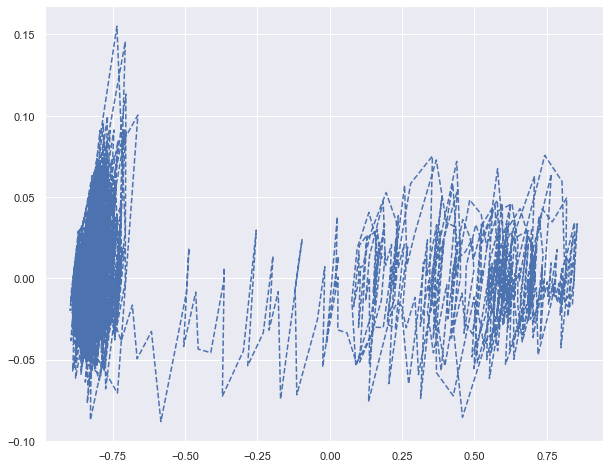

In [669]:
avg_polarization_1 = np.zeros(timesteps)
std_polarization_1 = np.zeros(timesteps)
delta_polarization_1 = np.zeros(timesteps)
avg_polarization_cos = np.zeros(timesteps)
std_polarization_cos = np.zeros(timesteps)
delta_polarization_cos = np.zeros(timesteps)
modder = 1

counterr = 0
for t in range(1,timesteps):
#for t in range(10):

#fork here
#for t in range(0,100):
    if t%modder == 0:
        counterr +=1
        
        #download particle data
        index = num_particles*t
        tmp_x = xpart[index: index+num_particles]
        tmp_y = ypart[index: index+num_particles]
        #tmp_theta = thetapart[index: index+num_particles]
        tmp_theta = thetapart_total[:, t]
        
        
        #calculate the angle between the target and the dog (ONLY FOR 1 DOG)
        tmp_target_angle = np.arctan2(y_target-y_dogs[index,0], x_target-x_dogs[index,0])
        # set color info
        tmp_colors = (tmp_theta - tmp_target_angle)%(2*np.pi) #colorator(tmp_theta)
        
        avg_polarization_1[t] = np.average(tmp_theta)
        avg_polarization_cos[t] = np.average(np.cos(tmp_theta))
        std_polarization_1[t] = np.std(tmp_theta)
        delta_polarization_1[t] = (avg_polarization_1[t]-avg_polarization_1[t-1])
        delta_polarization_cos[t] = (avg_polarization_cos[t]-avg_polarization_cos[t-1])
        


error_up = avg_polarization_1 + 2.0*std_polarization_1
error_down = avg_polarization_1 - 2.0*std_polarization_1
        
plt.figure(figsize = (10,8))
plt.plot(avg_polarization_cos[10:], delta_polarization_cos[10:], '--')
#plt.plot(np.arccos(avg_polarization_1), np.arccos(delta_polarization_1), '--')

In [670]:
np.min(thetapart[100:])

-15.704200614359173

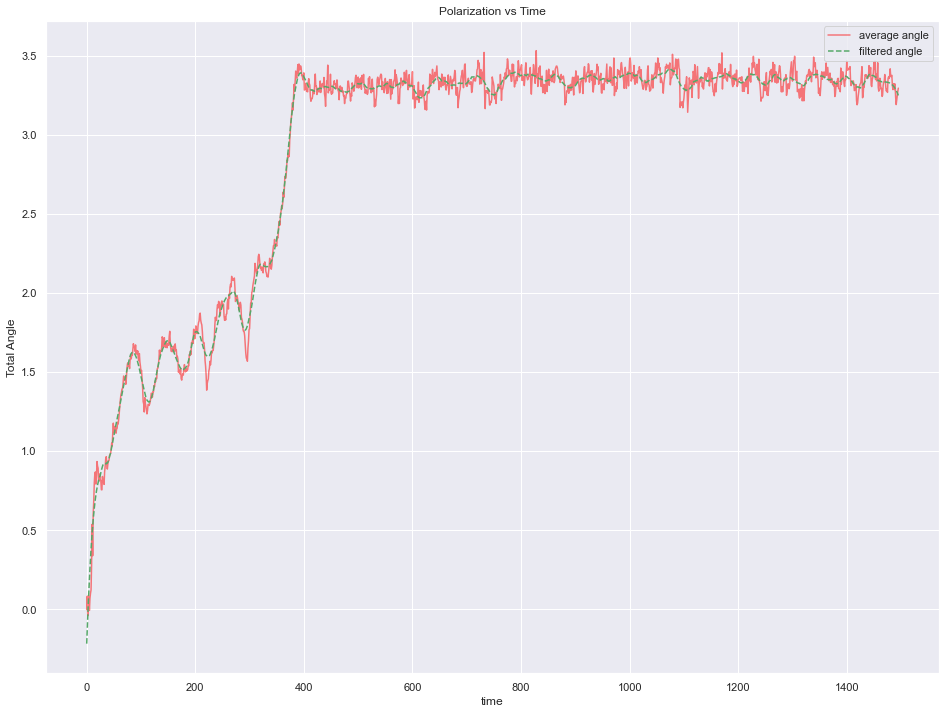

In [671]:
plt.figure(figsize = (16,12))
plt.title("Polarization vs Time")
plt.ylabel("Total Angle")
plt.xlabel("time")
# plt.plot(times, error_up)
# plt.plot(times, error_down)
#plt.fill_between(times, error_down, error_up, alpha=0.5, edgecolor='k', facecolor='#7EFF99', label = '2 std bound')
plt.plot(times, avg_polarization_1,'red', label = 'average angle', alpha = 0.5)#
#plt.plot(times, avg_polarization_1, 'red', label = 'average angle')#
#plt.plot(times, avg_polarization_smooth, '.', 'green', label = 'total average angle')
#plt.plot(times, delta_polarization_1, 'blue', label = 'delta polarization')
plt.plot(times, filtered_theta_avg, 'g--', label = 'filtered angle')
#plt.plot(times, filtered_dtheta_avg, 'c--', label = 'delta polarization')
#plt.xlim(50,100)
#plt.ylim(-2*np.pi, 2*np.pi)
#plt.xlim(4700, 4900)
#plt.ylim(-60,-50)
#plt.ylim()
plt.legend()
plt.savefig("polarization_vs_time_1.png")
#plt.savefig("total_avg_angle_droving.png")
#plt.savefig('total_avg_angle_mustering.png')
plt.show()

In [651]:
# filtered_theta_avg = fft_denoiser(avg_polarization_1, 8)
# filtered_dtheta_avg = [filtered_theta_avg[kk]-filtered_theta_avg[kk-1] for kk in range(len(filtered_theta_avg))]

In [673]:
from scipy.signal import savgol_filter
filtered_theta_avg = savgol_filter(avg_polarization_1, 51, 3)
filtered_dtheta_avg = savgol_filter([filtered_theta_avg[kk]-filtered_theta_avg[kk-1] for kk in range(len(filtered_theta_avg))], 101, 3)

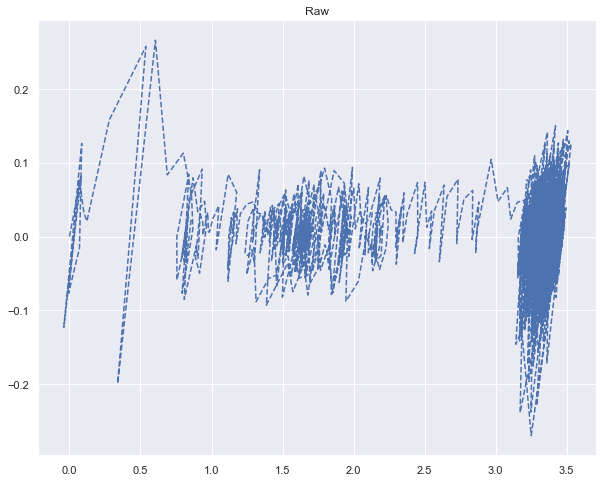

In [674]:
plt.figure(figsize = (10,8))
plt.title('Raw')
plt.plot(avg_polarization_1, delta_polarization_1,'--')

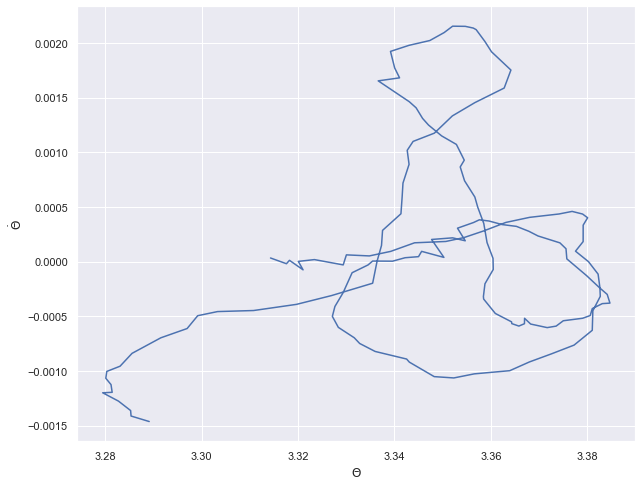

In [681]:
plt.figure(figsize = (10,8))
plt.xlabel("$\Theta$")
plt.ylabel("$ \dot \Theta$")
#plt.plot(filtered_theta_avg[100:-100], filtered_dtheta_avg[100:-100])
#plt.plot(filtered_theta_avg[100:1000], filtered_dtheta_avg[100:1000]) #mustering case 1
#plt.plot(filtered_theta_avg[100:300], filtered_dtheta_avg[100:300]) #driving case 1
#plt.plot(filtered_theta_avg[6000:8000], filtered_dtheta_avg[6000:8000]) #mustering case 1
#plt.plot(filtered_theta_avg[400:600], filtered_dtheta_avg[400:600]) #droving--good case 1
plt.plot(filtered_theta_avg[1100:1250], filtered_dtheta_avg[1100:1250])
#plt.ylim(-0.01,0.01)
#plt.xlim(-100, -50)
#plt.xlim(4700, 4900)
#plt.plot(avg_polarization_1, delta_polarization_1,'--')
plt.savefig("theta_vs_thetadot_1.png")

9759


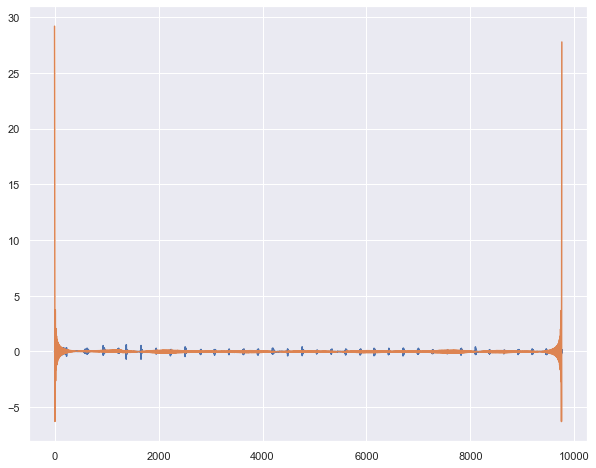

In [490]:
print(timesteps)
plt.figure(figsize = (10,8))
plt.plot(delta_polarization_smooth)
plt.plot(filtered_dtheta_avg)

In [401]:
print(np.max(delta_polarization_1), np.argmax(delta_polarization_1))
print(np.min(delta_polarization_1), np.argmin(delta_polarization_1))

0.59937464 1
-0.5304840200000001 1234


In [402]:
print(avg_polarization_1[np.argmax(delta_polarization_1)-2:np.argmax(delta_polarization_1)+2])
print(avg_polarization_1[np.argmin(delta_polarization_1)-2:np.argmin(delta_polarization_1)+2])

[]
[ 0.47778936  0.1956169  -0.33486712 -0.74037251]


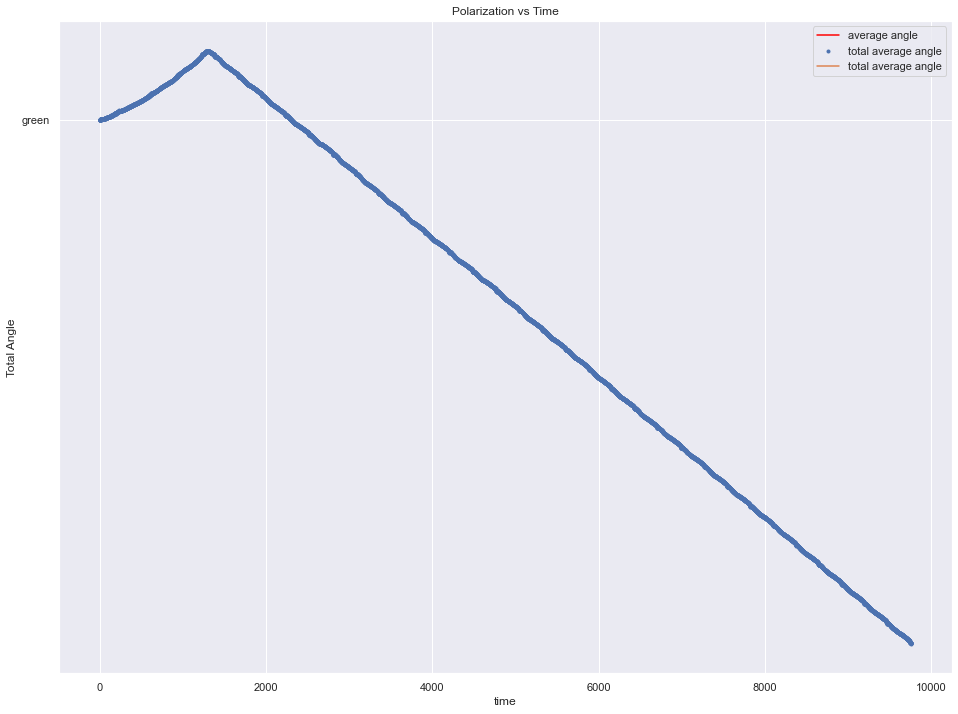

In [445]:


plt.figure(figsize = (16,12))
plt.title("Polarization vs Time")
plt.ylabel("Total Angle")
plt.xlabel("time")
# plt.plot(times, error_up)
# plt.plot(times, error_down)
#plt.fill_between(times, error_down, error_up, alpha=0.5, edgecolor='k', facecolor='#7EFF99', label = '2 std bound')
plt.plot(times, avg_polarization_1, 'red', label = 'average angle')#
plt.plot(times, avg_polarization_smooth, '.', 'green', label = 'total average angle')
#plt.plot(times, delta_polarization_1, 'blue', label = 'delta polarization')
#plt.xlim(50,100)
#plt.ylim(-2*np.pi, 2*np.pi)
plt.legend()
# plt.savefig("total_avg_angle_droving.png")
#plt.savefig("total_avg_angle_droving.png")
#plt.savefig('total_avg_angle_mustering.png')
plt.show()




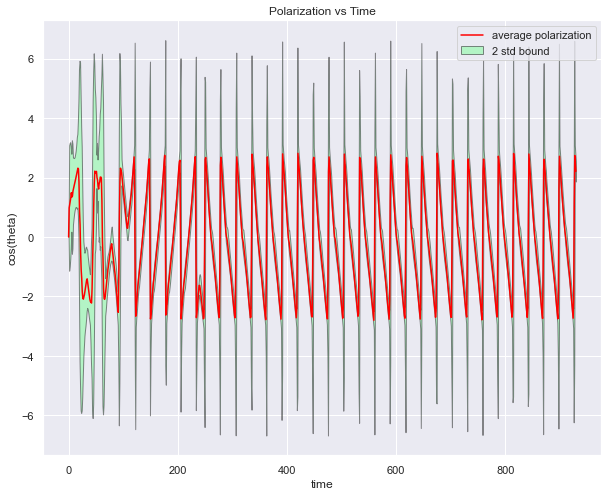

In [227]:
# avg_polarization_1 = np.zeros(timesteps)
# std_polarization_1 = np.zeros(timesteps)
# delta_polarization_1 = np.zeros(timesteps)
# modder = 1

# counterr = 0
# for t in range(timesteps):
# #for t in range(10):

# #fork here
# #for t in range(0,100):
#     if t%modder == 0:
#         counterr +=1
        
#         #download particle data
#         index = num_particles*t
#         tmp_x = xpart[index: index+num_particles]
#         tmp_y = ypart[index: index+num_particles]
#         tmp_theta = thetapart[index: index+num_particles]
        
        
#         #calculate the angle between the target and the dog (ONLY FOR 1 DOG)
#         tmp_target_angle = np.arctan2(y_target-y_dogs[index,0], x_target-x_dogs[index,0])
#         # set color info
#         tmp_colors = (tmp_theta - tmp_target_angle)%(2*np.pi) #colorator(tmp_theta)
        
#         avg_polarization_1[t] = np.average(tmp_theta) #np.average(np.cos(tmp_theta)) #np.average(tmp_colors) #np.average(tmp_theta)
#         std_polarization_1[t] = np.std(np.cos(tmp_theta))

        


# error_up = avg_polarization_1 + 2.0*std_polarization_1
# error_down = avg_polarization_1 - 2.0*std_polarization_1
        
plt.figure(figsize = (10,8))
plt.title("Polarization vs Time")
plt.ylabel("cos(theta)")
plt.xlabel("time")
# plt.plot(times, error_up)
# plt.plot(times, error_down)
plt.fill_between(times, error_down, error_up, alpha=0.5, edgecolor='k', facecolor='#7EFF99', label = '2 std bound')
plt.plot(times, avg_polarization_1, 'red', label = 'average polarization')
plt.legend()
plt.show()

In [23]:
np.shape(dat_field)

(3154300, 7)

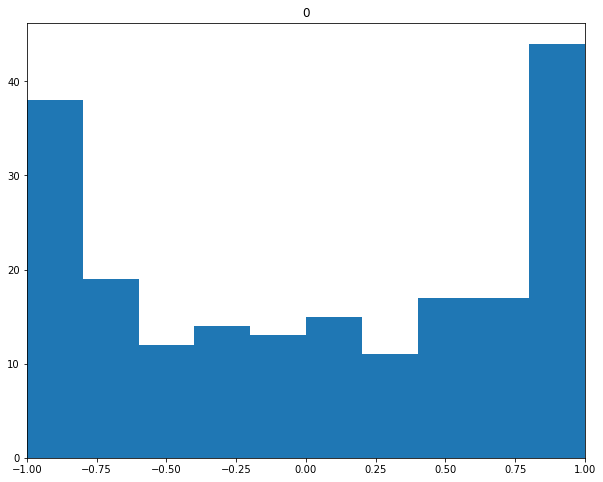

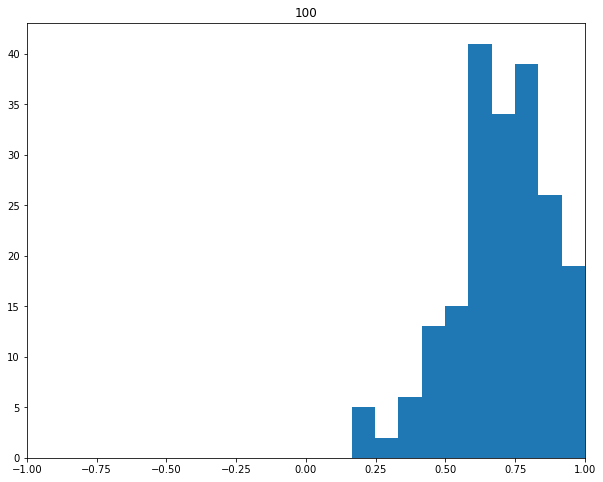

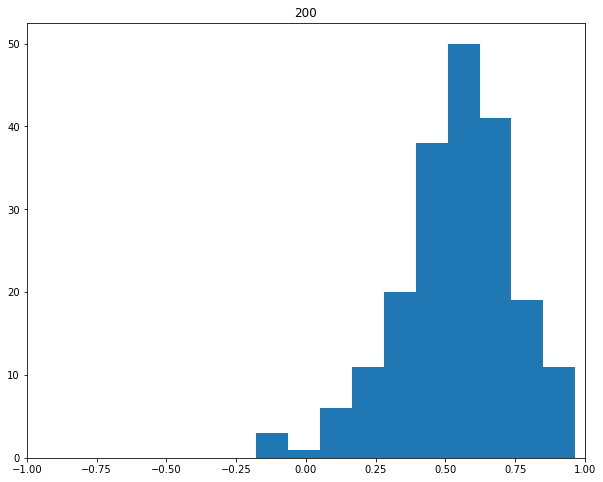

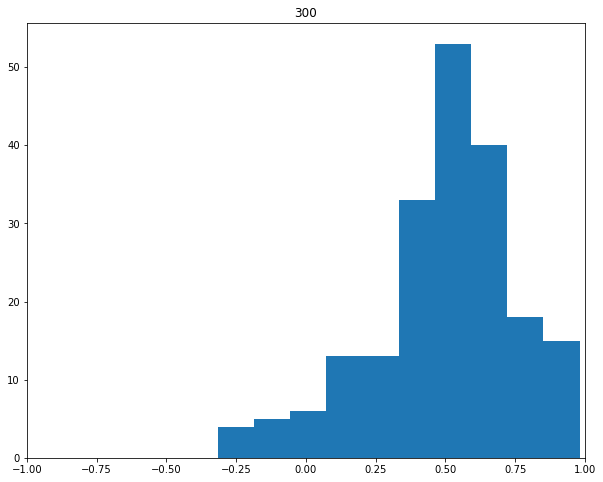

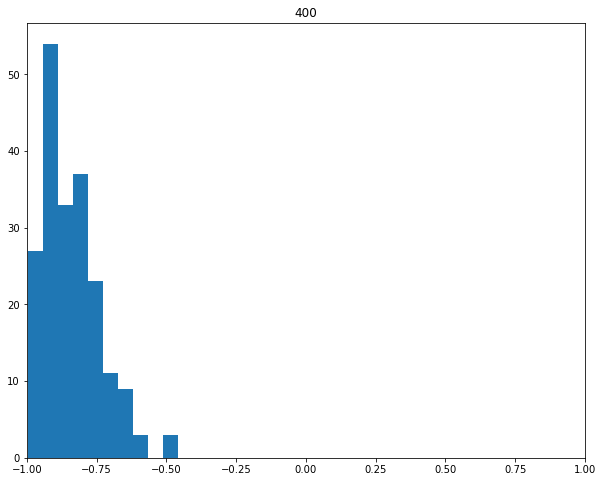

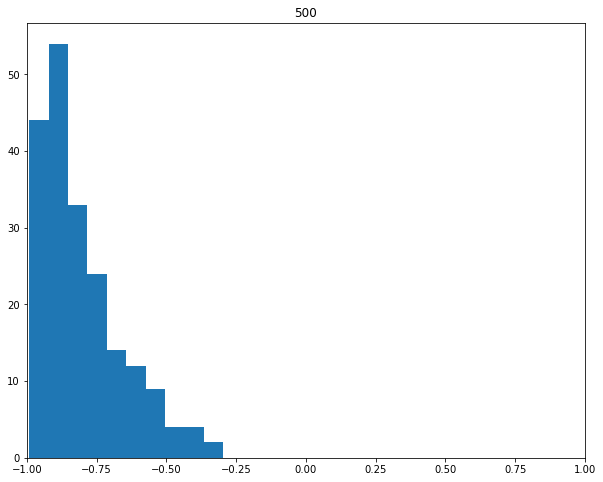

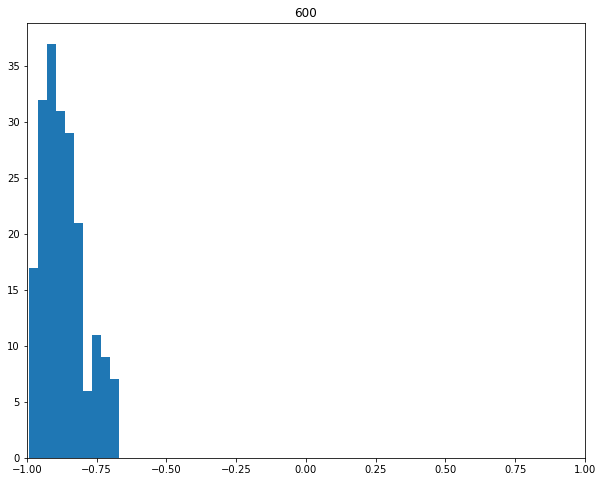

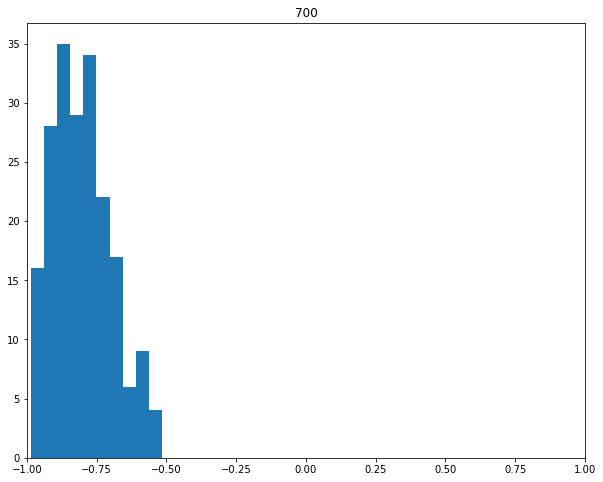

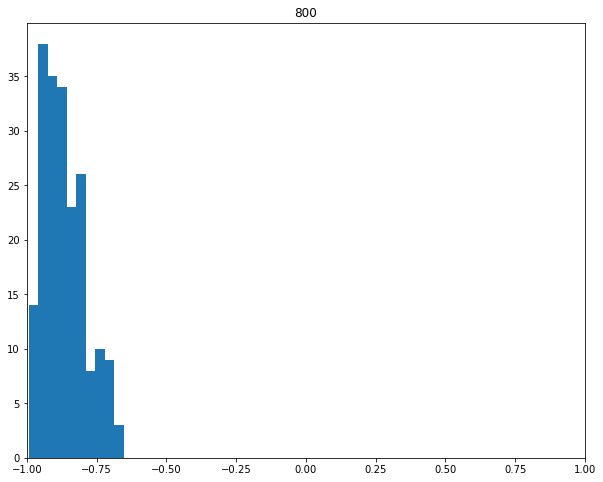

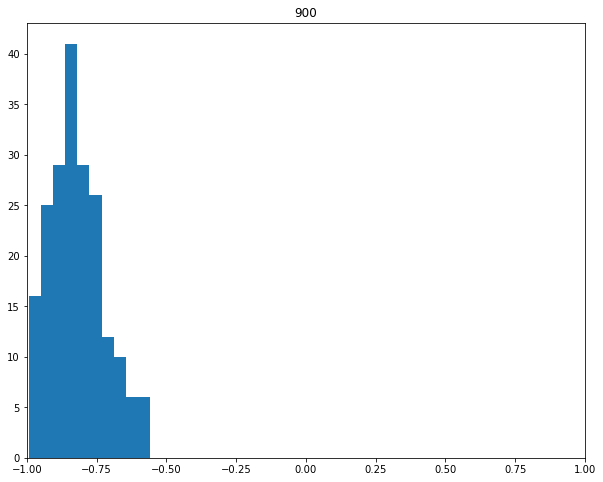

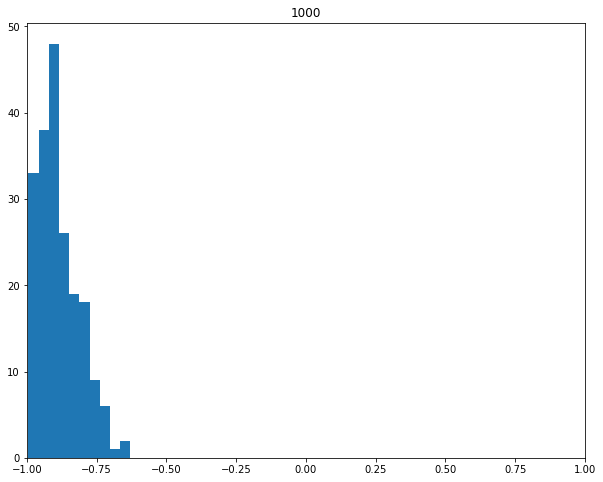

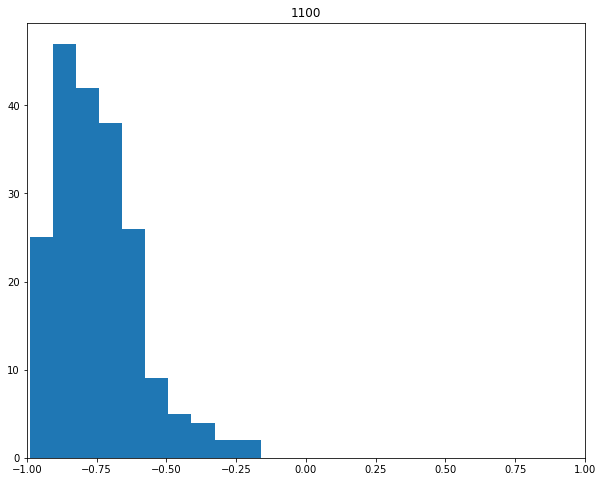

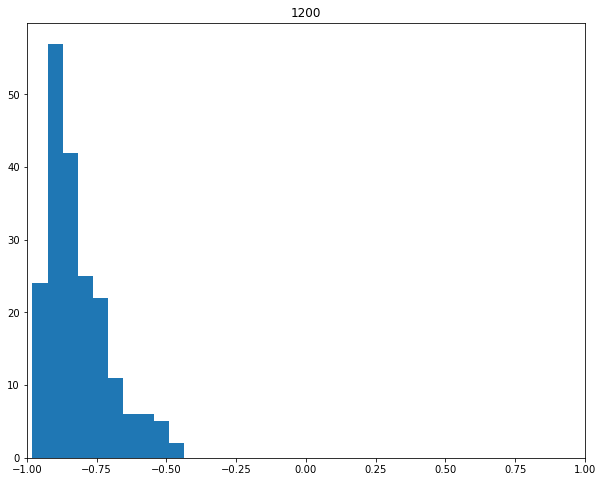

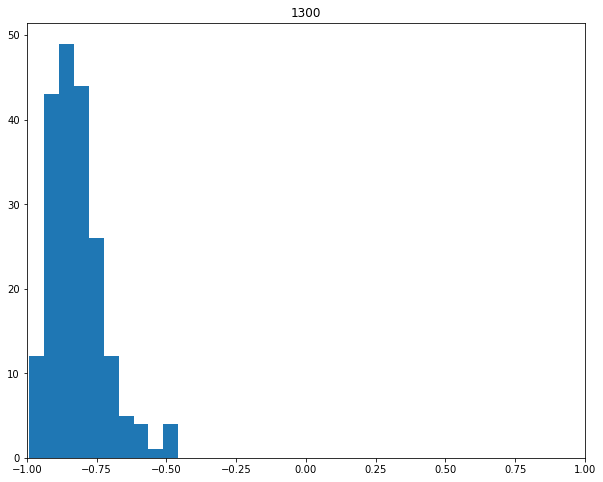

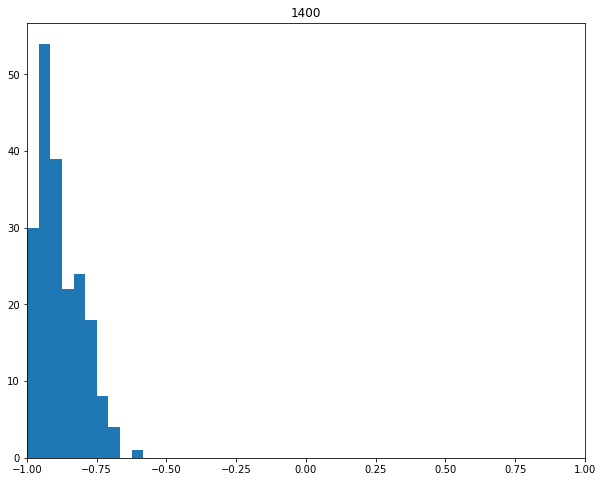

In [13]:
avg_polarization_1 = np.ones(timesteps)
modder = 100

counterr = 0
for t in range(timesteps):
#for t in range(10):

#fork here
#for t in range(1000, 1030):
    if t%modder == 0:
        counterr +=1
        
        #download particle data
        index = num_particles*t
        tmp_x = xpart[index: index+num_particles]
        tmp_y = ypart[index: index+num_particles]
        tmp_theta = thetapart[index: index+num_particles]
        
        
        #calculate the angle between the target and the dog (ONLY FOR 1 DOG)
        tmp_target_angle = np.arctan2(y_target-y_dogs[index,0], x_target-x_dogs[index,0])
        # set color info
        tmp_colors = (tmp_theta - tmp_target_angle)%(2*np.pi) #colorator(tmp_theta)
        
        avg_polarization_1[t] = np.average(tmp_theta) #np.average(tmp_colors) #np.average(tmp_theta)
        
        plt.figure(figsize = (10,8))
        plt.title(t)
        plt.hist(np.cos(tmp_theta))
        plt.xlim(-1,1)
        #plt.xlim(0, 2*np.pi)
        plt.show()
        
# plt.figure(figsize = (10,8))
# plt.plot(times, avg_polarization_1, '.')

## In this section, we look at the herd area over time and try to extract timescales

In [ ]:
plt.figure(figsize = (10,8))
plt.title("Herd area (L4 norm) over time")
plt.xlabel("time")
plt.ylabel("Estimated herd area")
plt.plot(times[1:], l4_norm)
plt.show()